In [1]:
import numpy as np
import matplotlib.pyplot as plt
from distrx.transforms import (
  delta_method,
  transform_data,
  transform_percentage_change,
  transform_percentage_change_counts1,
  transform_percentage_change_counts2
)
NREP = 300
Q = 1.96

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Univariate Simulations

/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_12398/746050651.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_txs[i], sigma_tx = transform_data([x_bar], [sigma_hat], "log", "delta")
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_12398/746050651.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ci_uppers[i] = mu_txs[i] + Q * sigma_tx / np.sqrt(N)
/var/folders/55/53rfb8cd7bd3rvs9lvgv5zyw0000gn/T/ipykernel_12398/746050651.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing 

CI coverage rate:  288


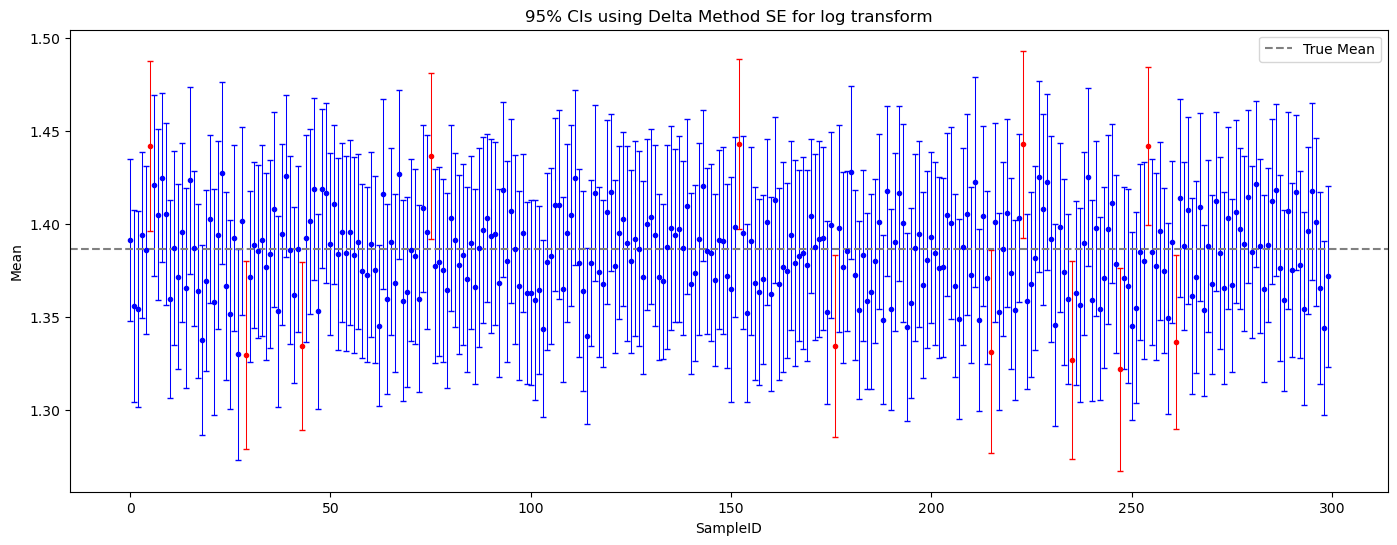

In [2]:
# log transformation
MU = 4
SIGMA = 1
N = 100
LOG_MU = np.log(MU)
coverages = np.zeros(NREP)
mu_txs = np.zeros(NREP)
ci_uppers = np.zeros(NREP)
ci_lowers = np.zeros(NREP)

for i in range(NREP):
  data = np.random.normal(MU, SIGMA, N)
  x_bar = np.mean(data)
  sigma_hat = np.std(data)
  mu_txs[i], sigma_tx = transform_data([x_bar], [sigma_hat], "log", "delta")
  ci_uppers[i] = mu_txs[i] + Q * sigma_tx / np.sqrt(N)
  ci_lowers[i] = mu_txs[i] - Q * sigma_tx / np.sqrt(N)
  if (ci_lowers[i] < LOG_MU and LOG_MU < ci_uppers[i]):
    coverages[i] = 1

coverage_pct = (coverages == 1).sum()
print("CI coverage rate: ", coverage_pct)

# plotting
line_width = 0.75
cap_size = 2
marker_size = 3
plt.figure(figsize=(17, 6))
for i in range(NREP):
  if coverages[i] == 1:
    plt.errorbar(i, mu_txs[i], elinewidth=line_width,
                 yerr=[[mu_txs[i]- ci_lowers[i]], [ci_uppers[i] - mu_txs[i]]],
                 fmt="o", color="blue", ecolor="blue", capsize=cap_size, markersize=marker_size)
  else:
        plt.errorbar(i, mu_txs[i], elinewidth=line_width,
                     yerr=[[mu_txs[i] - ci_lowers[i]], [ci_uppers[i] - mu_txs[i]]],
                     fmt="o", color="red", ecolor="red", capsize=cap_size, markersize=marker_size)

plt.axhline(y=LOG_MU, color='gray', linestyle='--')
plt.xlabel('SampleID')
plt.ylabel("Mean")
plt.title("95% CIs using Delta Method SE for log transform")
plt.legend(["True Mean"], loc="upper right")
plt.show()

# Bivariate Simulations

## Percentage Change
* the function that currently works as intended calculates percentage change in prevalence rates
  * note: prevalence is analogous to mean, just with binary data
* the function that simply calculates percentage change in counts does not currently work
  * in my experience, the RV is a function of consistent estimators, counts don't fall into that category
  * not completely certain that the above *must* be the case, perhaps just computing variance incorrectly?
  * tried both the formula in our overleaf and simply $np(1 - p)$ for variance

In [3]:
# parameters for population sizes and prevalence
Y1_POP, Y1_PREV = 1000, 0.49
Y2_POP, Y2_PREV = 1050, (Y1_PREV + 0.02)

# simulate incidence from 2 years w/differing aforementioned parameters
y1_incid = np.random.binomial(Y1_POP, Y1_PREV, size=NREP)
y2_incid = np.random.binomial(Y2_POP, Y2_PREV, size=NREP)

# true difference in prevalence
TRUE_DIFF = (Y2_PREV / Y1_PREV) - 1
print("True percentage change in proportions: ", TRUE_DIFF)
print("10 replications of incidence counts in year 1: ", y1_incid[0:9])

True percentage change in proportions:  0.04081632653061229
10 replications of incidence counts in year 1:  [473 507 492 479 491 475 465 509 504]


CI coverage rate:  0.95


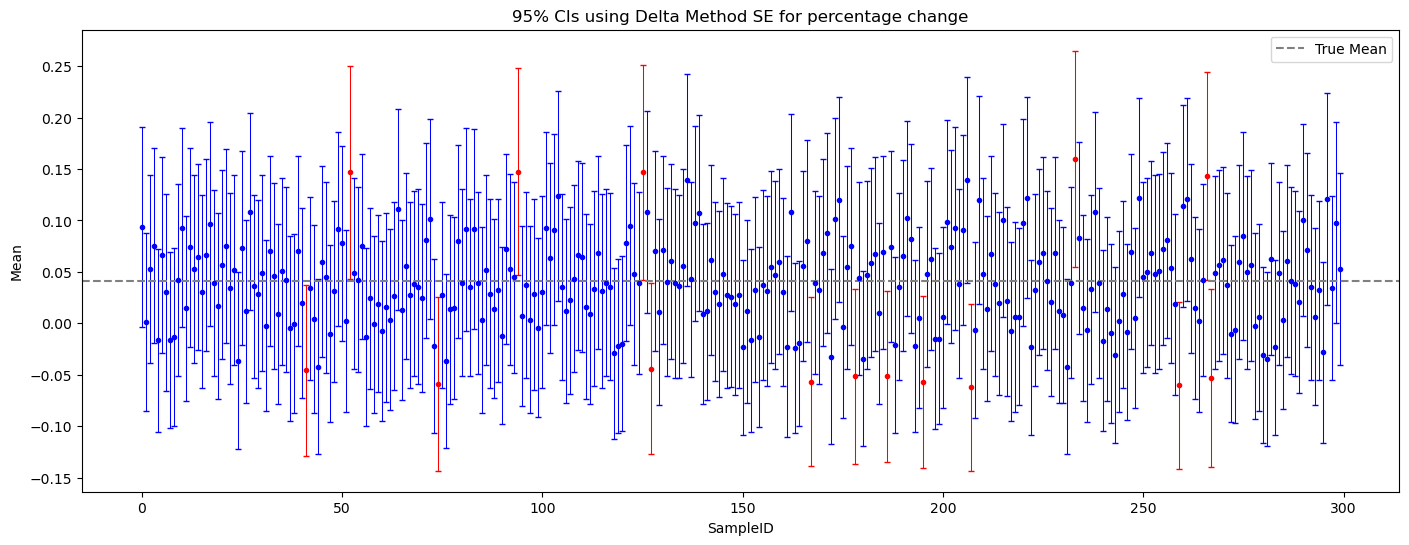

In [4]:
coverages = np.zeros(NREP)
mu_txs = np.zeros(NREP)
ci_uppers = np.zeros(NREP)
ci_lowers = np.zeros(NREP)
y1_rep1 = y1_incid[0]
y2_rep1 = y2_incid[0]

# print(transform_percentage_change_counts1(y1_rep1, Y1_POP, y2_rep1, Y2_POP))
# print(transform_percentage_change_counts2(y1_rep1, Y1_POP, y2_rep1, Y2_POP))

for i in range(NREP):
  mu_txs[i], sigma_hat = transform_percentage_change_counts2(y1_incid[i], Y1_POP, y2_incid[i], Y2_POP)
  # print(delta_hat, sigma_hat)
  ci_uppers[i] = mu_txs[i] + Q * sigma_hat / np.sqrt(Y1_POP)
  ci_lowers[i] = mu_txs[i] - Q * sigma_hat / np.sqrt(Y1_POP)
  if (ci_lowers[i] < TRUE_DIFF and TRUE_DIFF < ci_uppers[i]):
    coverages[i] = 1

coverage_pct = (coverages == 1).sum() / NREP
print("CI coverage rate: ", coverage_pct)

line_width = 0.75
cap_size = 2
marker_size = 3
plt.figure(figsize=(17, 6))
for i in range(NREP):
  if coverages[i] == 1:
    plt.errorbar(i, mu_txs[i], elinewidth=line_width,
                 yerr=[[mu_txs[i]- ci_lowers[i]], [ci_uppers[i] - mu_txs[i]]],
                 fmt="o", color="blue", ecolor="blue", capsize=cap_size, markersize=marker_size)
  else:
        plt.errorbar(i, mu_txs[i], elinewidth=line_width,
                     yerr=[[mu_txs[i] - ci_lowers[i]], [ci_uppers[i] - mu_txs[i]]],
                     fmt="o", color="red", ecolor="red", capsize=cap_size, markersize=marker_size)

plt.axhline(y=TRUE_DIFF, color='gray', linestyle='--')
plt.xlabel('SampleID')
plt.ylabel("Mean")
plt.title("95% CIs using Delta Method SE for percentage change")
plt.legend(["True Mean"], loc="upper right")
plt.show()

It seems as though the CI length is wider than it should be at more extreme values of prevalence (i.e. those near 0 or 1). This is probably due to the fact that when computing the CI, the standard error was divided by the sample size of the first year. Unclear as to what it should be instead, any suggestions?